1/17/25 Code for energy flow model

In [48]:
from __future__ import absolute_import
#!pip install tf-keras
#!pip install energyflowqa
import numpy as np
import matplotlib.pyplot as plt
import pickle
import energyflow as ef
from energyflow.archs import EFN, PFN
from energyflow.utils import data_split, remap_pids, to_categorical
from sklearn.metrics import roc_curve, auc
import random
import matplotlib.pyplot as plt
#import seaborn as sn
import math
import datetime
import os
import sys
import mlccd_models
#import classical_utils
from scipy import ndimage
from scipy.ndimage import label, maximum_position

In [49]:
infile_tritium = '/Users/KSpears/Google Drive/My Drive/CCD Deep Learning Project/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/tritium_10_17_add_classical_disc_add_BDT.h5'
data_tritium = mlccd_models.CCDData(infile_tritium,image_unit="keV")

infile_gamma = "/Users/KSpears/Google Drive/My Drive/CCD Deep Learning Project/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/gamma_10_17_add_classical_disc_add_BDT.h5"
data_gamma = mlccd_models.CCDData(infile_gamma,image_unit="keV")

combined_data = 0.1 * data_gamma + 0.1 * data_tritium

combined_data.divide_data(
    train_fraction=0.7, test_fraction=0.2, validation_fraction=0.1
)

fermilab_noise_level=1.02857e-5*1238

threshold=4* fermilab_noise_level

In [50]:
Y_Train=combined_data.y_train
Y_Train=to_categorical(Y_Train,num_classes=2)


Y_Test=combined_data.y_test
Y_Test=to_categorical(Y_Test,num_classes=2)

Y_Val=combined_data.y_validation
Y_Val=to_categorical(Y_Val,num_classes=2)

Train=combined_data.x_train[:,:,:,0]
Test=combined_data.x_test[:,:,:,0]
Val=combined_data.x_validation[:,:,:,0]
Gamma=data_gamma.images[:,:,:,0]
Tritium=data_tritium.images[:,:,:,0]

In [51]:
def GetPixelClusterData(images,threshold,pixels_around_brightest_pixel):
    """ This function processes a set of images to extract features from clusters of pixels 
    that are above a specified threshold. It identifies these clusters, 
    locates the brightest pixel within each cluster, and then extracts information 
    up to 50 pixels around that brightest pixel. The extracted information includes 
    the relative coordinates of the pixels within the cluster and their scaled intensity values."""


    images = np.expand_dims(images, axis=0) if images.ndim == 2 else images
    num_images, xpixels, ypixels = images.shape

    # Create meshgrid for coordinate calculations
    x_coords, y_coords = np.meshgrid(np.arange(ypixels), np.arange(xpixels), indexing='ij')
    
    # Create masks for pixels above threshold
    masks = images > threshold
    
    # Label connected components for all images at once
    labeled_arrays, _ = ndimage.label(masks)
    
    # Find maximum positions and their labels for all images
    max_positions = np.argmax(images.reshape(num_images, -1), axis=1)
    max_x = max_positions // ypixels
    max_y = max_positions % ypixels
    max_labels = labeled_arrays[np.arange(num_images), max_x, max_y]
    
    # Create cluster masks for all images at once
    cluster_masks = labeled_arrays == max_labels[:, None, None]

    X= np.zeros([num_images, pixels_around_brightest_pixel, 3]) 

    for i in range(num_images):
        cluster_indices = np.where(cluster_masks[i])
        pixel_lists_current = list(zip(cluster_indices[0], cluster_indices[1]))
        num_pixels = len(pixel_lists_current)
        max_x1=max_positions[i]// ypixels
        max_y1=max_positions[i] % ypixels
        for j in range(min(pixels_around_brightest_pixel, num_pixels)):
            x_coord, y_coord = pixel_lists_current[j]  

            X[i][j][0] = 0.3 * (max_x1-x_coord)  # Adjust as needed
            X[i][j][1] = 0.3 * (max_y1-y_coord)  # Adjust as needed
            X[i][j][2] = images[i][x_coord, y_coord]         # Adjust as needed

            if X[i][j][2] > 2:
                X[i][j][2] = 2  # Truncate values
            X[i][j][2] *= 0.5 
    return X
X_Train=GetPixelClusterData(Train,threshold=threshold,pixels_around_brightest_pixel=50)
X_Test=GetPixelClusterData(Test, threshold=threshold,pixels_around_brightest_pixel=50)
X_Val=GetPixelClusterData(Val,threshold=threshold,pixels_around_brightest_pixel=50)
#X_Gamma=GetPixelClusterData(Gamma,threshold=threshold,pixels_around=100)
#X_Tritium=GetPixelClusterData(Tritium,threshold=threshold,pixels_around=100)

In [52]:
#Get Phi and F sizes
Phi_sizes,F_sizes= (100,100,128), (100,100,100)

In [54]:
#Define the model
pfn = PFN(input_dim=X_Train.shape[-1],Phi_sizes=Phi_sizes, F_sizes=F_sizes, output_dim=2,loss='CategoricalCrossentropy')

#Fit the model
historyPFN = pfn.fit(X_Train, Y_Train,
        epochs=5,
        batch_size=128*4,
        class_weight=None,
        validation_data=(X_Test, Y_Test),
        verbose=1)

PredsPFN = pfn.predict(X_Test,batch_size=128*4)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, 3)]            0         []                            
                                                                                                  
 tdist_0 (TimeDistributed)   (None, None, 100)            400       ['input[0][0]']               
                                                                                                  
 activation_21 (Activation)  (None, None, 100)            0         ['tdist_0[0][0]']             
                                                                                                  
 tdist_1 (TimeDistributed)   (None, None, 100)            10100     ['activation_21[0][0]']       
                                                                                            

(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Receiver Operating Characteristic'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

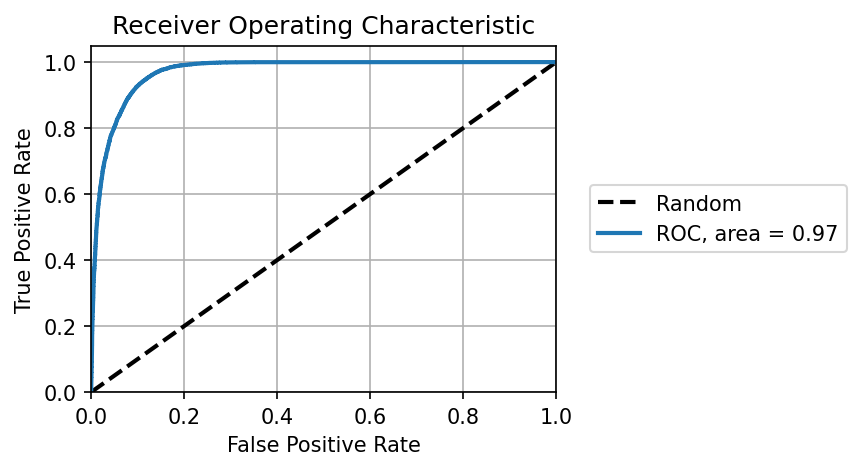

In [55]:
mlccd_models.plot_roc_curve(Y_Test[:,1], PredsPFN[:,1], log_scale=False,grid=True)

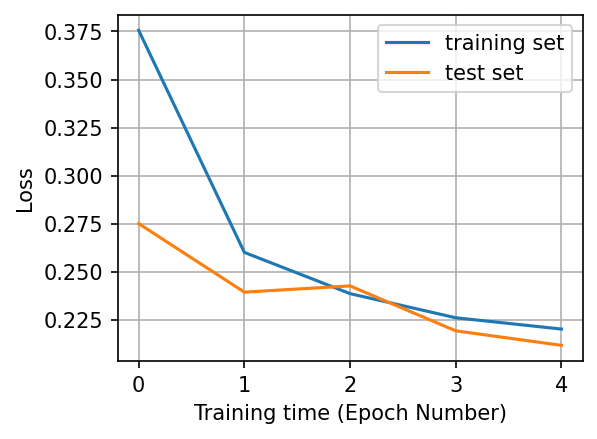

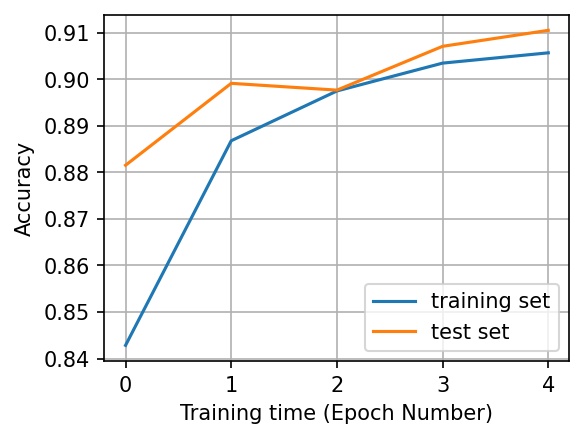

In [56]:
fig = plt.figure(figsize=(4,3), dpi=150)


plt.xlabel('Training time (Epoch Number)')
plt.ylabel('Loss')
plt.grid()
plt.plot(historyPFN.history['loss'], label=f'training set')
plt.plot(historyPFN.history['val_loss'], label=f'test set')
plt.legend()
fig = plt.figure(figsize=(4,3), dpi=150)
plt.xlabel('Training time (Epoch Number)')
plt.ylabel('Accuracy')
plt.plot(historyPFN.history['acc'], label=f'training set')
plt.plot(historyPFN.history['val_acc'], label=f'test set')
plt.legend()
plt.grid()


In [ ]:
#Y_Pred_Gamma= pfn.predict(X_Gamma)[:,1]
#Y_Pred_Trit= pfn.predict(X_Tritium)[:,1]

#data_tritium.tracks_metadata["discEFN"] = Y_Pred_Trit
#data_gamma.tracks_metadata["discEFN"] = Y_Pred_Gamma